In [1]:
# importing packages
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import os
%matplotlib inline

# Camera Calibration and Image Undistortion

In [2]:
def calibrate_camera(cal_img_path):
    """
    Calibrate the camera given a directory which contains calibration chessboards.
    """
    # Read in all calibration images in a given file directory
    images = glob.glob(os.path.join(cal_img_path, 'calibration*.jpg'))

    # Creat arrays to store object (3D pints in real-world space) points and image points (2D points on image)
    obj_points = []
    img_points = []

    # Prepare object points
    obj_p = np.zeros((6*9, 3), np.float32)
    obj_p[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    for img_fname in images:
        # Read in images
        chessboard = cv2.imread(img_fname)
        # Convert chessboard image to gray scale
        gray_chess = cv2.cvtColor(chessboard, cv2.COLOR_BGR2GRAY)
        # Find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray_chess, (9, 6), None)

        # If corners are found, add image points and object points
        if ret==True:
            img_points.append(corners)
            obj_points.append(obj_p)

            # Draw corners on the image
            chessboard = cv2.drawChessboardCorners(chessboard, (9, 6), corners, ret)

    # Calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray_chess.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

In [3]:
def undistort(distorted_img, mtx, dist):
    """
    Undistort a distorted image and given a calibration matrix.
    """
    undist_img = cv2.undistort(distorted_img, mtx, dist, None, mtx)
    
    return undist_img

**Let's test the functions on a test image!**

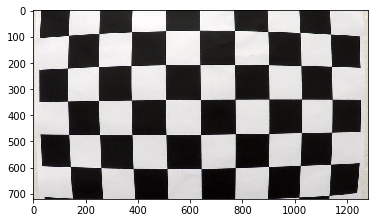

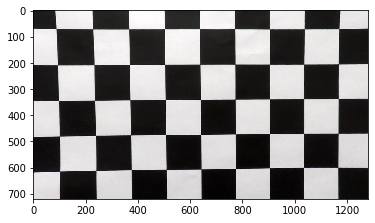

In [4]:
ret, mtx, dist, rvecs, tvecs = calibrate_camera("camera_cal")
chessboard = mpimg.imread("camera_cal/calibration1.jpg")
undist_chessboard = undistort(chessboard, mtx, dist)
plt.figure()
plt.imshow(chessboard)
mpimg.imsave('output_images/chessboard.jpg', chessboard)
plt.figure()
plt.imshow(undist_chessboard)
mpimg.imsave('output_images/undist_chessboard.jpg', undist_chessboard)

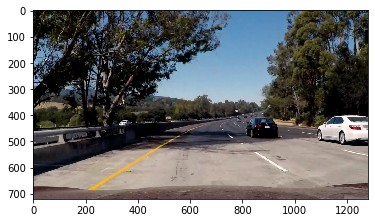

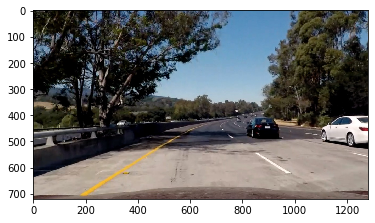

In [5]:
test_image = mpimg.imread("test_images/test5.jpg")
undist_test_img = undistort(test_image, mtx, dist)
plt.figure()
plt.imshow(test_image)
mpimg.imsave('output_images/test_img.jpg', test_image)
plt.figure()
plt.imshow(undist_test_img)
mpimg.imsave('output_images/undist_test_img.jpg', undist_test_img)

# Gradients and Color Transform

In [8]:
def gaussian_blur(img, kernel_size=5):
    """
    Applies a Gaussian Noise kernel
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def sobel_abs_threshold(img, orient, sobel_kernel, thresh):
    """
    Calculate gradient in x and y directions and apply the threshold
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the derivative in x or y given orient = 'x' or 'y'
    # Take the absolute value of the derivative or gradient
    if orient == 'x':
        sobel_abs = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        sobel_abs = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel_abs = np.uint8(255*sobel_abs/np.max(sobel_abs))
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    # Return this mask as your binary_output image
    binary_output = np.zeros_like(sobel_abs)
    binary_output[(sobel_abs >= thresh[0]) & (sobel_abs <= thresh[1])] = 1
    
    return binary_output
    
def sobel_mag_threshold(img, sobel_kernel, mag_thresh):
    """
    Calculate the magnitude of the gradient and apply the threshold
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    grad_mag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    grad_mag = np.uint8(255*grad_mag/np.max(grad_mag))
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(grad_mag)
    binary_output[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1

    return binary_output
    
def sobel_dir_threshold(img, sobel_kernel, dir_thresh):
    """
    Calculate the direction of the gradient and apply the threshold  
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir>dir_thresh[0]) & (grad_dir<dir_thresh[1])] = 1

    return binary_output

def sobel_threshold(img, kernel_size):
    """
    Combine all the gradient thresholds together
    """
    # gradient thresholds in x and y directions
    grad_x = sobel_abs_threshold(img, orient='x', sobel_kernel=kernel_size, thresh=(20, 255))
    grad_y = sobel_abs_threshold(img, orient='y', sobel_kernel=kernel_size, thresh=(20, 255))
    # gradient magnitude threshold
    grad_mag = sobel_mag_threshold(img, sobel_kernel=kernel_size, mag_thresh=(40, 255))
    # gradient direction threshold
    grad_dir = sobel_dir_threshold(img, sobel_kernel=kernel_size, dir_thresh=(0, 0.85*np.pi/2))
    # Combine different thresholds
    sobel_combined = np.zeros_like(grad_dir)
    sobel_combined[(grad_mag==1) & (grad_dir==1)] = 1
    
    return sobel_combined

def color_threshold_hls(img, channel, thresh):
    """
    Apply the threshold in HLS colorspace 
    """
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Apply a threshold to the selected channel
    if channel=='h':
        h_channel = hls[:,:,0]
        binary_output = np.zeros_like(h_channel)
        binary_output[(h_channel>thresh[0]) & (h_channel<=thresh[1])] = 1
    elif channel=='l':
        l_channel = hls[:,:,1]
        binary_output = np.zeros_like(l_channel)
        binary_output[(l_channel>thresh[0]) & (l_channel<=thresh[1])] = 1
    else:
        s_channel = hls[:,:,2]
        binary_output = np.zeros_like(s_channel)
        binary_output[(s_channel>thresh[0]) & (s_channel<=thresh[1])] = 1
    
    return binary_output
                                   
def color_threshold_rgb(img, channel, thresh):
    """
    Apply the threshold in RGB colorspace 
    """
    # Apply a threshold to the selected channel
    if channel=='r':
        r_channel = img[:,:,0]
        binary_output = np.zeros_like(r_channel)
        binary_output[(r_channel>thresh[0]) & (r_channel<=thresh[1])] = 1
    elif channel=='g':
        g_channel = img[:,:,1]
        binary_output = np.zeros_like(g_channel)
        binary_output[(g_channel>thresh[0]) & (g_channel<=thresh[1])] = 1
    else:
        b_channel = img[:,:,2]
        binary_output = np.zeros_like(b_channel)
        binary_output[(b_channel>thresh[0]) & (b_channel<=thresh[1])] = 1

    return binary_output

def color_threshold_hsv(img, channel, thresh):
    """
    Apply the threshold in HLS colorspace 
    """
    # Convert to HLS color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Apply a threshold to the selected channel
    if channel=='h':
        h_channel = hsv[:,:,0]
        binary_output = np.zeros_like(h_channel)
        binary_output[(h_channel>thresh[0]) & (h_channel<=thresh[1])] = 1
    elif channel=='s':
        s_channel = hsv[:,:,1]
        binary_output = np.zeros_like(s_channel)
        binary_output[(s_channel>thresh[0]) & (s_channel<=thresh[1])] = 1
    else:
        v_channel = hsv[:,:,2]
        binary_output = np.zeros_like(v_channel)
        binary_output[(v_channel>thresh[0]) & (v_channel<=thresh[1])] = 1
    
    return binary_output

def create_binary_frame(img):
    """
    Combine all the thresholds together
    """
    # Apply Gaussian blur to the image to reduce the noise
    blurred_img = gaussian_blur(img)
    # Sobel threshold
    sobel_binary = sobel_threshold(blurred_img, 3)
    # color threshold
    color_binary1 = color_threshold_hls(blurred_img, 'h', (10, 50)) # yellow line
    color_binary2 = color_threshold_hls(blurred_img, 's', (80, 255)) # yellow line
    color_binary3 = color_threshold_hls(blurred_img, 'l', (210, 255)) # white line
    color_binary4 = color_threshold_rgb(blurred_img, 'r', (210, 255)) # white line
    # Combine Sobel and color thresholds
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[(sobel_binary==1) | (((color_binary1==1) & (color_binary2==1)) | ((color_binary3==1) | (color_binary4==1)))] = 1
    
    return combined_binary

**Let's try the thresholds!**

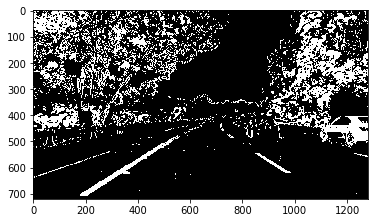

In [25]:
undist_binary_test = create_binary_frame(undist_test_img)
plt.figure()
plt.imshow(undist_binary_test, cmap='gray')
mpimg.imsave('output_images/binary_test_img.jpg', undist_binary_test, cmap='gray')

# Perspective Transform

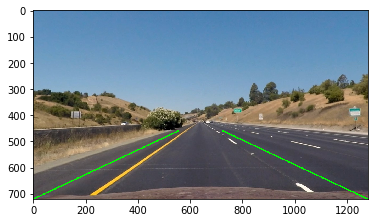

In [10]:
"""
Find source image vetices of the trapezoid whose 
two sides are parallel to the road lane by trial and error
"""
# Use a image with straight lines
straight_line_image = mpimg.imread("test_images/straight_lines1.jpg")
# Undistort the image
undist_straight_lines = undistort(straight_line_image, mtx, dist)
height, width = test_image.shape[0:2]
# Four vertices
left_bottom = [0, height]
right_bottom = [width, height]
left_top = [555, 460]
right_top = [725, 460]

# Plot the lines on the image to see the result
cv2.line(undist_straight_lines, (left_bottom[0], left_bottom[1]), (left_top[0], left_top[1]), (0,255,0), 3)
cv2.line(undist_straight_lines, (right_bottom[0], right_bottom[1]), (right_top[0], right_top[1]), (0,255,0), 3)
plt.imshow(undist_straight_lines)
mpimg.imsave('output_images/find_parallel_straight_lines.jpg', undist_straight_lines)

In [11]:
def perspective_transform(image):
    # Transform the image to bird's-eye view
    height, width = image.shape[0:2]
    # source points (use the points found in the previous cell)
    src = np.float32([[0, height],
                      [width, height],
                      [555, 460],
                      [725, 460]])
    # destination points
    dst = np.float32([[0, height],       
                      [width, height],       
                      [0, 0],       
                      [width, 0]]) 
    
    # Calculate the transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, (width, height), flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

**Let's see how it works!**

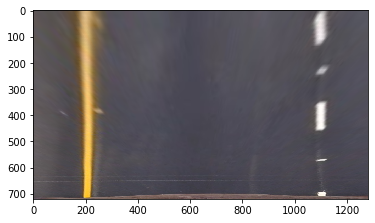

In [12]:
undist_straight_lines = undistort(straight_line_image, mtx, dist)
warped_straight_lines, M, Minv = perspective_transform(undist_straight_lines)
plt.imshow(warped_straight_lines)
mpimg.imsave('output_images/warped_straight_lines.jpg', warped_straight_lines)

**Let's apply the perspective transform on the undistorted binary image!**

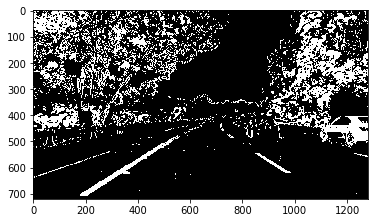

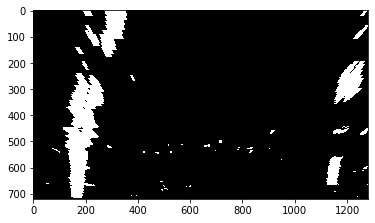

In [13]:
plt.figure()
plt.imshow(undist_binary_test, cmap='gray')
warped_binary_test, M, Minv = perspective_transform(undist_binary_test)
warped_binary_test[warped_binary_test>0] = 1
plt.figure()
plt.imshow(warped_binary_test, cmap='gray')
plt.savefig('output_images/warped_binary_test_img.jpg', cmap='gray')
#mpimg.imsave('output_images/warped_binary_test_img.jpg', warped_binary_test, cmap='gray')

# Lane Detection 

In [14]:
class Line():
    """
    Define a class to receive the characteristics of each line detection
    """
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x and y pixel values of the fitted lines
        self.fitx = None
        self.fity = None
        # x values of the last n fits of the line (at the bottom)
        self.recent_xfitted = deque()
        #average x values of the fitted line over the last n iterations (at the bottom)
        self.best_x = None     
        #polynomial coefficients in the last iteration
        self.last_fit_pixel = None  
        self.last_fit_meter = None  
        #polynomial coefficients over the last n iterations
        self.recent_fits_pixel = deque()  
        self.recent_fits_meter = deque()  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit_pixel = None
        self.best_fit_meter = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #x values for detected line pixels
        self.all_x_pixels = None  
        #y values for detected line pixels
        self.all_y_pixels = None  
    
    def update_line(self, poly_fit_pixel, poly_fit_meter, y_eval):
        self.last_fit_pixel = poly_fit_pixel
        self.last_fit_meter = poly_fit_meter
        # Append the polynomial coefficients to the deque
        self.recent_fits_pixel.append(self.last_fit_pixel)
        self.recent_fits_meter.append(self.last_fit_meter)
        # Remove the oldest polynomial coefficients if n is larger than 10
        if len(self.recent_fits_pixel)>10:
            self.recent_fits_pixel.popleft()
            self.recent_fits_meter.popleft()
        # Find the average polynomial coefficients
        self.best_fit_pixel = np.mean(self.recent_fits_pixel, axis=0)
        self.best_fit_meter = np.mean(self.recent_fits_meter, axis=0)
        # Calculate the radius of curvature at the bottom, which is closest to the car position
        self.radius_of_curvature = ((1 + (2*self.best_fit_meter[0]*y_eval*ym_per_pix + self.best_fit_meter[1])**2)**1.5) / np.absolute(2*self.best_fit_meter[0])

In [15]:
def fit_polynomial(left_line, right_line, y_eval):
    """
    Fit the left and right lines polynomial (in both pixel and meter) given the pixel positions
    """
    if len(left_line.all_x_pixels)>0:
        left_line.detected = True
        left_fit_pixel = np.polyfit(left_line.all_y_pixels, left_line.all_x_pixels, 2)
        left_fit_meter = np.polyfit(left_line.all_y_pixels*ym_per_pix, left_line.all_x_pixels*xm_per_pix, 2)
    else:
        left_line.detected = False
        left_fit_pixel = left_line.last_fit_pixel
        left_fit_meter = left_line.last_fit_meter
        
    if len(right_line.all_x_pixels)>0:
        right_line.detected = True
        right_fit_pixel = np.polyfit(right_line.all_y_pixels, right_line.all_x_pixels, 2)
        right_fit_meter = np.polyfit(right_line.all_y_pixels*ym_per_pix, right_line.all_x_pixels*xm_per_pix, 2)
    else:
        right_line.detected = False
        right_fit_pixel = right_line.last_fit_pixel
        right_fit_meter = right_line.last_fit_meter
    
    # Do the line update
    left_line.update_line(left_fit_pixel, left_fit_meter, y_eval)
    right_line.update_line(right_fit_pixel, left_fit_meter, y_eval)
    
    return left_line, right_line

In [16]:
def find_lane_pixels_by_sliding_windows(undist_img, warped_binary, left_line, right_line, plot=False):
    """
    Find lines by using sliding windows from the bottom of the image. 
    The starting points of the left and right lines are the highest peaks from the left and right halves of the histogram of the activated binary pixels. 
    Then we slide the search windows toward the top of the image and identify all the lane-line pixels.
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    bird_eye_with_lines = np.dstack((warped_binary, warped_binary, warped_binary))*255
    bird_eye_with_lines = np.ascontiguousarray(bird_eye_with_lines, dtype=np.uint8)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(warped_binary.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binary.shape[0] - (window + 1)*window_height
        win_y_high = warped_binary.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        if plot==True:
            cv2.rectangle(bird_eye_with_lines,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(bird_eye_with_lines,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
             
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window
        #('right' or 'leftx_current') on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    
    # Extract left and right line pixel positions
    left_line.all_x_pixels = nonzerox[left_lane_inds]
    left_line.all_y_pixels = nonzeroy[left_lane_inds] 
    right_line.all_x_pixels = nonzerox[right_lane_inds]
    right_line.all_y_pixels = nonzeroy[right_lane_inds]

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = warped_binary.shape[0] - 1
    # Fit the polynomial with the found pixels
    left_line, right_line = fit_polynomial(left_line, right_line, y_eval)
    
    # Generate x and y values of the polynomial for plotting
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0])
    left_line.fitx = left_line.best_fit_pixel[0]*ploty**2 + left_line.best_fit_pixel[1]*ploty + left_line.best_fit_pixel[2]
    right_line.fitx = right_line.best_fit_pixel[0]*ploty**2 + right_line.best_fit_pixel[1]*ploty + right_line.best_fit_pixel[2]
    left_line.fity = ploty
    right_line.fity = ploty
    
    # Append x position of the lines at the bottom, which will be used to calculate the offset
    left_line.recent_xfitted.append(left_line.best_fit_pixel[0]*(warped_binary.shape[0]-1)**2 + left_line.best_fit_pixel[1]*(warped_binary.shape[0]-1) + left_line.best_fit_pixel[2])
    right_line.recent_xfitted.append(right_line.best_fit_pixel[0]*(warped_binary.shape[0]-1)**2 + right_line.best_fit_pixel[1]*(warped_binary.shape[0]-1) + right_line.best_fit_pixel[2])
    # Remove the oldest x position if n is larger than 10
    if len(left_line.recent_xfitted)>10:
        left_line.recent_xfitted.popleft()
    if len(right_line.recent_xfitted)>10:
        right_line.recent_xfitted.popleft()
    # Find the average of the x positions
    left_line.bestx = np.mean(left_line.recent_xfitted, axis=0)
    right_line.bestx = np.mean(right_line.recent_xfitted, axis=0)
    
    # Colors in the left and right lane regions in bird's-eye view
    bird_eye_with_lines[left_line.all_y_pixels, left_line.all_x_pixels] = [255, 0, 0]
    bird_eye_with_lines[right_line.all_y_pixels, right_line.all_x_pixels] = [0, 0, 255]
    
    if plot==True:
        # Plots the left and right polynomials on the lane lines
        plt.figure()
        plt.imshow(bird_eye_with_lines)
        plt.plot(left_line.fitx, left_line.fity, color='yellow')
        plt.plot(right_line.fitx, right_line.fity, color='yellow')
        plt.savefig('output_images/bird_eye_with_lines.jpg')

    return left_line, right_line, bird_eye_with_lines

In [17]:
def find_lane_pixels_by_searching_around_poly(undist_img, warped_binary, left_line, right_line, plot=False):
    """
    Find lines by searching around the polynomial from the previous frame within a given margin.
    """
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_line.best_fit_pixel[0]*(nonzeroy**2) + left_line.best_fit_pixel[1]*nonzeroy + 
                    left_line.best_fit_pixel[2] - margin)) & (nonzerox < (left_line.best_fit_pixel[0]*(nonzeroy**2) + 
                    left_line.best_fit_pixel[1]*nonzeroy + left_line.best_fit_pixel[2] + margin)))
    right_lane_inds = ((nonzerox > (right_line.best_fit_pixel[0]*(nonzeroy**2) + right_line.best_fit_pixel[1]*nonzeroy + 
                    right_line.best_fit_pixel[2] - margin)) & (nonzerox < (right_line.best_fit_pixel[0]*(nonzeroy**2) + 
                    right_line.best_fit_pixel[1]*nonzeroy + right_line.best_fit_pixel[2] + margin)))
    
    # Again, extract left and right line pixel positions
    left_line.all_x_pixels = nonzerox[left_lane_inds]
    left_line.all_y_pixels = nonzeroy[left_lane_inds] 
    right_line.all_x_pixels = nonzerox[right_lane_inds]
    right_line.all_y_pixels = nonzeroy[right_lane_inds]
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = warped_binary.shape[0] - 1
    # Fit new polynomials
    left_line, right_line = fit_polynomial(left_line, right_line, y_eval)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0])
    left_line.fitx = left_line.best_fit_pixel[0]*ploty**2 + left_line.best_fit_pixel[1]*ploty + left_line.best_fit_pixel[2]
    right_line.fitx = right_line.best_fit_pixel[0]*ploty**2 + right_line.best_fit_pixel[1]*ploty + right_line.best_fit_pixel[2]
    left_line.fity = ploty
    right_line.fity = ploty
    
    # Append x position of the lines at the bottom, which will be used to calculate the offset
    left_line.recent_xfitted.append(left_line.best_fit_pixel[0]*(warped_binary.shape[0]-1)**2 + left_line.best_fit_pixel[1]*(warped_binary.shape[0]-1) + left_line.best_fit_pixel[2])
    right_line.recent_xfitted.append(right_line.best_fit_pixel[0]*(warped_binary.shape[0]-1)**2 + right_line.best_fit_pixel[1]*(warped_binary.shape[0]-1) + right_line.best_fit_pixel[2])
    # Remove the oldest x position if n is larger than 10
    if len(left_line.recent_xfitted)>10:
        left_line.recent_xfitted.popleft()
    if len(right_line.recent_xfitted)>10:
        right_line.recent_xfitted.popleft()
    # Find the average of the x positions
    left_line.bestx = np.mean(left_line.recent_xfitted, axis=0)
    right_line.bestx = np.mean(right_line.recent_xfitted, axis=0)
    
    # Create an image to draw on and an image to show the selection window
    bird_eye_with_lines = np.dstack((warped_binary, warped_binary, warped_binary))*255
    bird_eye_with_lines = np.ascontiguousarray(bird_eye_with_lines, dtype=np.uint8)
    window_img = np.zeros_like(bird_eye_with_lines)
    # Color in left and right line pixels
    bird_eye_with_lines[left_line.all_y_pixels, left_line.all_x_pixels] = [255, 0, 0]
    bird_eye_with_lines[right_line.all_y_pixels, right_line.all_x_pixels] = [0, 0, 255]
    
    if plot==True:
        # Plots the left and right polynomials on the lane lines
        plt.figure()
        plt.imshow(bird_eye_with_lines)
        plt.plot(left_line.fitx, left_line.fity, color='yellow')
        plt.plot(right_line.fitx, right_line.fity, color='yellow')
        plt.savefig('output_images/bird_eye_with_lines.jpg')
    
    return left_line, right_line, bird_eye_with_lines

In [18]:
def draw_onto_road(undist_img, warped_binary, bird_eye_with_lines, left_line, right_line, Minv):
    """
    Draw the found lane back down onto the road.
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))*255

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.fitx, left_line.fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.fitx, right_line.fity])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Draw left and right lines onto the image
    color_warp[left_line.all_y_pixels, left_line.all_x_pixels] = [255, 0, 0]
    color_warp[right_line.all_y_pixels, right_line.all_x_pixels] = [0, 0, 255]

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0])) 
    # Combine the result with the original image
    output_road_image = cv2.addWeighted(undist_img, 1, newwarp, 0.7, 0)
    
    # Scale the bird's-eye-view image which will be added onto the road image
    height, width = bird_eye_with_lines.shape[0:2]
    scale_ratio = 0.2
    scaled_h, scaled_w = int(scale_ratio*height), int(scale_ratio*width)
    bird_eye_with_lines = cv2.resize(bird_eye_with_lines, (scaled_w, scaled_h))
    
    # Overlay the bird's-eye-view image onto the road image
    (x_offset, y_offset) = (20, 20)
    output_road_image[y_offset:y_offset + scaled_h, x_offset:x_offset + scaled_w, :] = bird_eye_with_lines
    
    return output_road_image
    

In [19]:
def calculate_offset(left_line, right_line):
    """
    Calculate the offset from the lane center
    """
    offset = (int(image_w/2) - (left_line.bestx + right_line.bestx)/2)*xm_per_pix
    return offset

# Pipeline
Let's put all the things together to create the pipeline!

In [20]:
def process_image(image):
    """
    Create the pipeline
    """
    global left_line, right_line, image_w, ym_per_pix, xm_per_pix, processed_frames
    image_w = image.shape[1]
    # Undistort the image
    undist_img = undistort(image, mtx, dist)
    # Create binary image
    undist_binary = create_binary_frame(undist_img)
    # Perspective transform
    warped_binary, M, Minv = perspective_transform(undist_binary)
    #warped_binary = cv2.warpPerspective(undist_binary, M, (width, height), flags=cv2.INTER_LINEAR)
    warped_binary = warped_binary.astype(int)
    # If the both lines in the previous frame are detected, 
    # search the lines in the current frame around the previous polynomials of the lines
    if processed_frames>0 and left_line.detected and right_line.detected:
        left_line, right_line, bird_eye_with_lines = find_lane_pixels_by_searching_around_poly(undist_img, warped_binary, left_line, right_line)
    elif processed_frames==0:
        # Assign plot=True to plot the bird's-eye view and save the image for the very first frame
        left_line, right_line, bird_eye_with_lines = find_lane_pixels_by_sliding_windows(undist_img, warped_binary, left_line, right_line, plot=True)
    else:
        left_line, right_line, bird_eye_with_lines = find_lane_pixels_by_sliding_windows(undist_img, warped_binary, left_line, right_line)
    
    # output of the road image
    output_road_image = draw_onto_road(undist_img, warped_binary, bird_eye_with_lines, left_line, right_line, Minv)
    # Calculate the radius of curvature
    mean_curvature = (left_line.radius_of_curvature + right_line.radius_of_curvature)/2
    cv2.putText(output_road_image, 'Radius of Curvature: {:.2f}m'.format(mean_curvature), (580, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA) 
    # Calculate the offset
    offset = calculate_offset(left_line, right_line)
    if offset>0:
        cv2.putText(output_road_image, 'Vehicle is {:.2f}m right from the lane center'.format(offset), (580, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
    else:
        cv2.putText(output_road_image, 'Vehicle is {:.2f}m left from the lane center'.format(-offset), (580, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
    
    processed_frames += 1
    
    return output_road_image

**Let's test our pipeline on an image!**

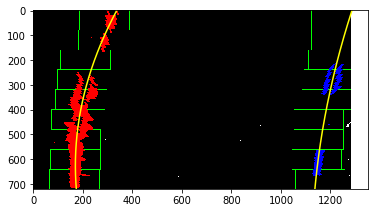

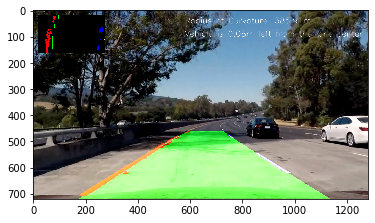

In [24]:
processed_frames = 0
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
left_line = Line()
right_line = Line()
# Always calibrate the camera first!
ret, mtx, dist, rvecs, tvecs = calibrate_camera("camera_cal")
test = mpimg.imread("test_images/test5.jpg")
test_image_output = process_image(test)
plt.figure()
plt.imshow(test_image_output)
mpimg.imsave('output_images/test_img_output.jpg', test_image_output)

**Let's test our pipeline in a video!**

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

t:   0%|          | 2/1260 [00:00<01:51, 11.25it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 12min 44s, sys: 1min 4s, total: 13min 48s
Wall time: 3min 18s


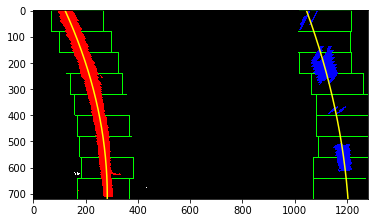

In [23]:
processed_frames = 0
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
left_line = Line()
right_line = Line()
ret, mtx, dist, rvecs, tvecs = calibrate_camera("camera_cal")
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))